In [2]:
import numpy as np
import sys
import os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
from utilities_new_new import *

c:\Users\Me\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
name = "XGBClassifier"
data_subdir = "eFEX_GEP_test"
accept_data_filename = "l1calo_topocluster_test_Zee.root"
reject_data_filename = "ZMUMU_TopoCluster_Supercell_Large.root"
distance_boundaries = [0.0125,0.025,0.05,0.1,0.2,0.4]

In [ ]:
save_path = os.path.join(os.path.pardir, "data", data_subdir)
# if os.path.exists(os.path.join(save_path, "np_data.npz")) and os.path.exists(os.path.join(save_path, "input_df.parquet")):
if os.path.exists(os.path.join(save_path, "np_data.npz")):
    print(f"found preprepared data in {save_path}")
    np_data = np.load(os.path.join(save_path, "np_data.npz"))
    input_np1, input_np2, labels_np = np_data["input_np1"], np_data["input_np2"], np_data["labels_np"]
    # input_df = pd.read_parquet(os.path.join(save_path, "input_df.parquet")) 

else:
    print(f"preprepared data in {save_path} is missing, preparing and saving here")
    accept_data_path = os.path.join(parent_dir, "data", accept_data_filename)
    reject_data_path = os.path.join(parent_dir, "data", reject_data_filename)
    DFs = import_data_files([accept_data_path, reject_data_path])
    accepted_numpy_eFEX = ak.to_numpy(DFs[0]['SuperCell_ET'])
    rejected_numpy_eFEX = ak.to_numpy(DFs[1]['SuperCell_ET'])
    print("attempting to generate topo training data")
    accepted_numpy_GEP = generate_topocluster_ET_distribution(DFs[0], distance_boundaries)
    rejected_numpy_GEP = generate_topocluster_ET_distribution(DFs[1], distance_boundaries)
    accepted_labels = np.ones(DFs[0].shape[0])
    rejected_labels = np.zeros(DFs[1].shape[0])
    # accepted_df = pd.DataFrame({'offline_ele_pt': DFs[0]['offline_ele_pt'], 'EventNumber': DFs[0]['EventNumber'], 'Label': 1})
    # rejected_df = pd.DataFrame({'offline_ele_pt': DFs[1]['offline_ele_pt'], 'EventNumber': DFs[0]['EventNumber'], 'Label': 0})
    
    input_np1 = np.concatenate((accepted_numpy_eFEX, rejected_numpy_eFEX), axis=0)
    input_np2 = np.concatenate((accepted_numpy_GEP, rejected_numpy_GEP), axis=0)
    labels_np = np.concatenate((accepted_labels, rejected_labels), axis=0)
    # input_df = pd.concat([accepted_df, rejected_df]).reset_index(drop=True)
    
    if not os.path.exists(save_path):
            os.mkdir(save_path)
    np.savez(os.path.join(save_path,"np_data.npz"), input_np1=input_np1, input_np2=input_np2, labels_np=labels_np)
    # input_df.to_parquet(os.path.join(save_path, "input_df.parquet"), index=False)

preprepared data in data\eFEX_GEP_test is missing, preparing and saving here
attempting to generate topo training data


100%|██████████| 535535/535535 [07:04<00:00, 1261.83it/s]


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data\\eFEX_GEP_test'

In [ ]:
# save_path = os.path.join(os.path.pardir, "data", data_subdir)
# os.mkdir(save_path)
# np.savez(os.path.join(save_path,"np_data.npz"), input_np1=input_np1, input_np2=input_np2, labels_np=labels_np)

In [8]:
X_train, X_test, X_train_topo, X_test_topo, y_train, y_test = train_test_split(input_np1, input_np2, labels_np, test_size=0.2, random_state=42)
Classifier = import_all_classifiers()[name]
clf = Classifier()
clf.fit(X_train, y_train)

if hasattr(clf, "decision_function"):  # For models like SVM or SGD
    y_scores = clf.decision_function(X_test)
elif hasattr(clf, "predict_proba"):  # For models like XGBoost or other tree-based models
    probs = clf.predict_proba(X_test)
    y_scores = probs[:, 1] if probs.shape[1] > 1 else probs[:, 0]


X_test_extended = np.hstack((X_test_topo, y_scores.reshape(-1, 1))) #not sure about reshaping
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_test_extended, y_test, test_size=0.2, random_state=42)
Classifier2 = import_all_classifiers()[name]
clf2 = Classifier()
clf2.fit(X_train2, y_train2)

# Evaluate second classifier
# y_pred1 = clf.predict(X_test2)
y_pred2 = clf2.predict(X_test2)
print("before second training with topo:")
# tn, fp, fn, tp, accuracy, recall, precision, f1, mse = evaluate_sklearn_model(y_test, y_pred1, classifier_name=f'{name}')
print("after second training with topo:")
tn, fp, fn, tp, accuracy, recall, precision, f1, mse = evaluate_sklearn_model(y_test2, y_pred2, classifier_name=f'{name}')

Imported 43 binary classifiers:
['AdaBoostClassifier', 'BaggingClassifier', 'BernoulliNB', 'CalibratedClassifierCV', 'CategoricalNB', 'ClassifierChain', 'ComplementNB', 'DecisionTreeClassifier', 'DummyClassifier', 'ExtraTreeClassifier', 'ExtraTreesClassifier', 'FixedThresholdClassifier', 'GaussianNB', 'GaussianProcessClassifier', 'GradientBoostingClassifier', 'HistGradientBoostingClassifier', 'KNeighborsClassifier', 'LabelPropagation', 'LabelSpreading', 'LinearDiscriminantAnalysis', 'LinearSVC', 'LogisticRegression', 'LogisticRegressionCV', 'MLPClassifier', 'MultiOutputClassifier', 'MultinomialNB', 'NearestCentroid', 'NuSVC', 'OneVsOneClassifier', 'OneVsRestClassifier', 'OutputCodeClassifier', 'PassiveAggressiveClassifier', 'Perceptron', 'QuadraticDiscriminantAnalysis', 'RadiusNeighborsClassifier', 'RandomForestClassifier', 'RidgeClassifier', 'RidgeClassifierCV', 'SGDClassifier', 'SVC', 'TunedThresholdClassifierCV', 'VotingClassifier', 'XGBClassifier']
Imported 43 binary classifiers:
[

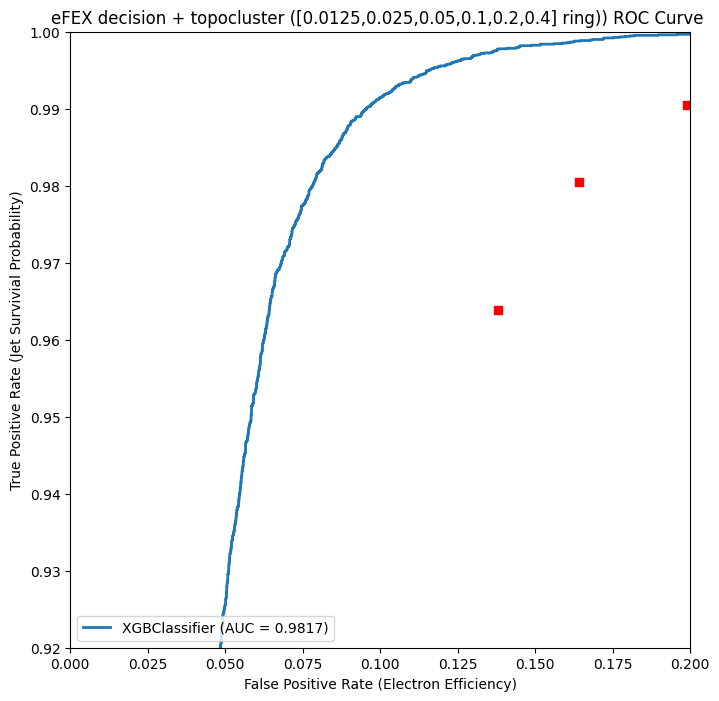

In [18]:
rejection_rates_heuristic =  [0.0, 0.8009311588352441, 0.8357150546315733, 0.8618870768071478]
id_efficiencies_heuristic = [1.0, 0.9905439553132065, 0.9805160260672962, 0.9638515760074478]
fpr, tpr, roc_auc = compute_roc(clf2, X_test2, y_test2)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 0.2])
plt.ylim([0.92, 1.0])
plt.xlabel('False Positive Rate (Electron Efficiency)')
plt.ylabel('True Positive Rate (Jet Survivial Probability)')
plt.title( 'eFEX decision + topocluster ([0.0125,0.025,0.05,0.1,0.2,0.4] ring)) ROC Curve ')
plt.legend(loc='lower left')
for i in range(1,4):
    plt.scatter(1.-rejection_rates_heuristic[i],id_efficiencies_heuristic[i], color='r', marker='s', label='Heuristic' if i == 1 else '')
plt.show()

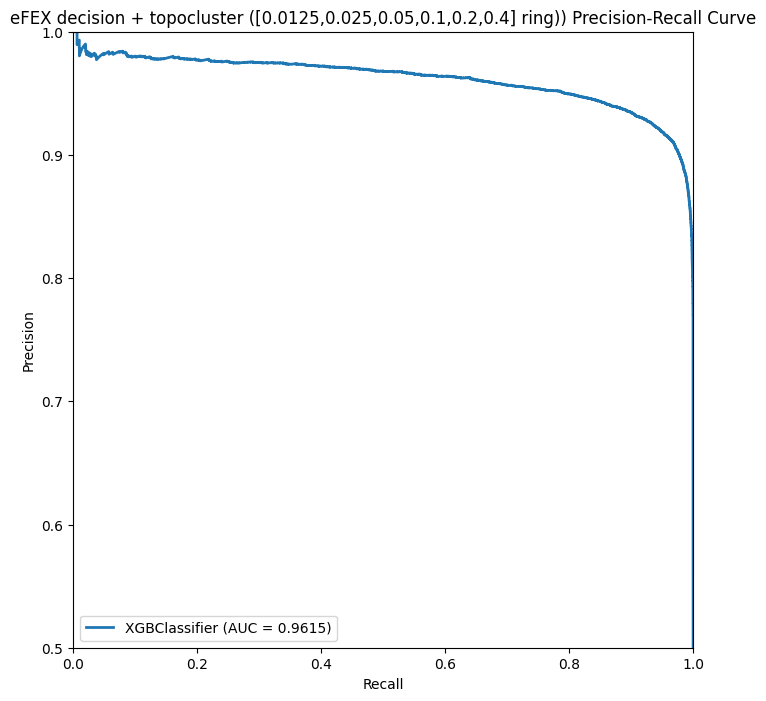

In [19]:
plt.figure(figsize=(8, 8))
precision_arr, recall_arr, pr_auc, chance_level = compute_precision_recall(clf2, X_test2, y_test2)
plt.plot(recall_arr, precision_arr, lw=2, label=f"{name} (AUC = {pr_auc:.4f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1])
plt.ylim([0.5, 1.0])
plt.title('eFEX decision + topocluster ([0.0125,0.025,0.05,0.1,0.2,0.4] ring)) Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [ ]:
bins, electrons_efficiency = compute_efficiency_vs_ele_PT(pd_passthrough_test, et_Low=20, et_High=60, prediction_parameter="pred")
plt.figure(figsize=(8,8))
plt.bar(bins[:-1], eff, width=np.diff(bins), alpha=0.5, align='edge', edgecolor='black')
plt.xlabel('Electron $p_T$')
plt.ylabel('Efficiency')
plt.title(' Recall vs Electron $p_T$ for '+classifier+"([0.0125,0.025,0.05,0.1,0.2,0.4] topocluster rings)")
plt.legend(loc='lower left')
plt.show()